<a href="https://colab.research.google.com/github/Aleksiiej/Machine-Learning/blob/main/neural_network_with_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# imports

import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from keras.utils import timeseries_dataset_from_array
from keras.saving import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
# reading data from .csv file

cols = list(pd.read_csv('PRSA_Data_Wanshouxigong_20130301-20170228.csv', nrows=1))
df = pd.read_csv('PRSA_Data_Wanshouxigong_20130301-20170228.csv',
                 usecols=[i for i in cols if i != "No" and i !='wd' and i != 'station'])
df["Date"] = pd.to_datetime(df[['year', 'month', 'day', 'hour']], format="%Y-%m-%d %H:%M")
df.drop(columns=['year', 'month', 'day', 'hour'], axis=1, inplace=True)
df.set_index('Date', drop=True, inplace=True)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2013-03-01 00:00:00 to 2017-02-28 23:00:00
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM2.5   34368 non-null  float64
 1   PM10    34580 non-null  float64
 2   SO2     34395 non-null  float64
 3   NO2     34310 non-null  float64
 4   CO      33767 non-null  float64
 5   O3      33986 non-null  float64
 6   TEMP    35045 non-null  float64
 7   PRES    35045 non-null  float64
 8   DEWP    35045 non-null  float64
 9   RAIN    35045 non-null  float64
 10  WSPM    35051 non-null  float64
dtypes: float64(11)
memory usage: 3.2 MB
None
              PM2.5          PM10           SO2          NO2            CO  \
count  34368.000000  34580.000000  34395.000000  34310.00000  33767.000000   
mean      85.024136    112.223459     17.148603     55.52956   1370.395031   
std       85.975981     97.593210     23.940834     35.80805   1223.139114   
min        3.0000

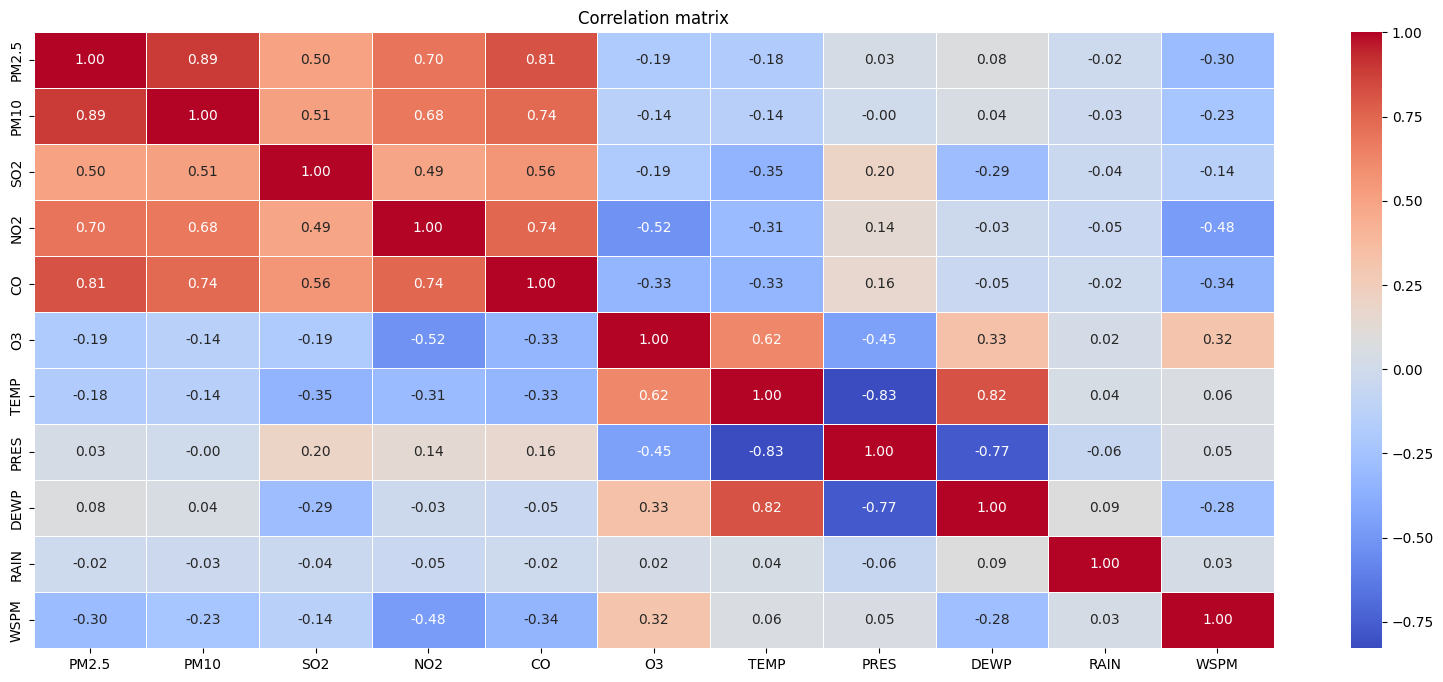

PM2.5     696
PM10      484
SO2       669
NO2       754
CO       1297
O3       1078
TEMP       19
PRES       19
DEWP       19
RAIN       19
WSPM       13
dtype: int64


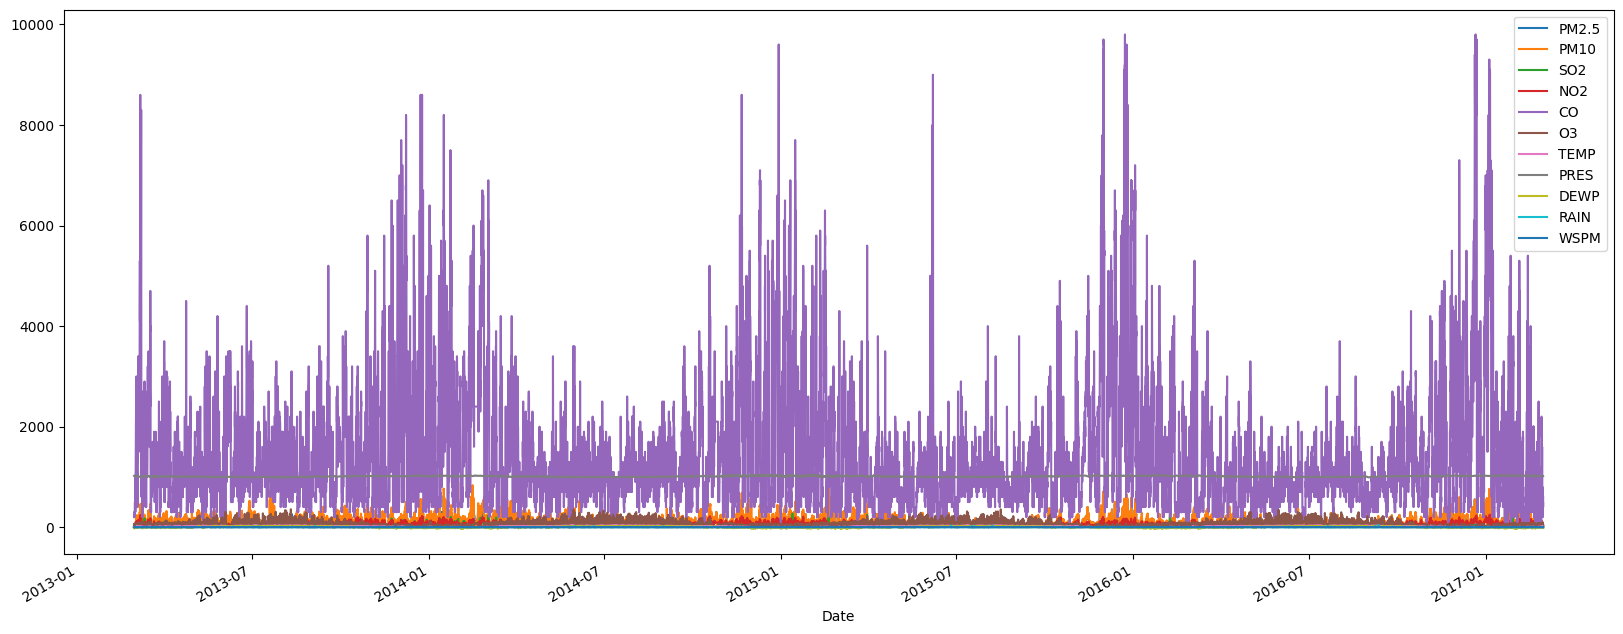

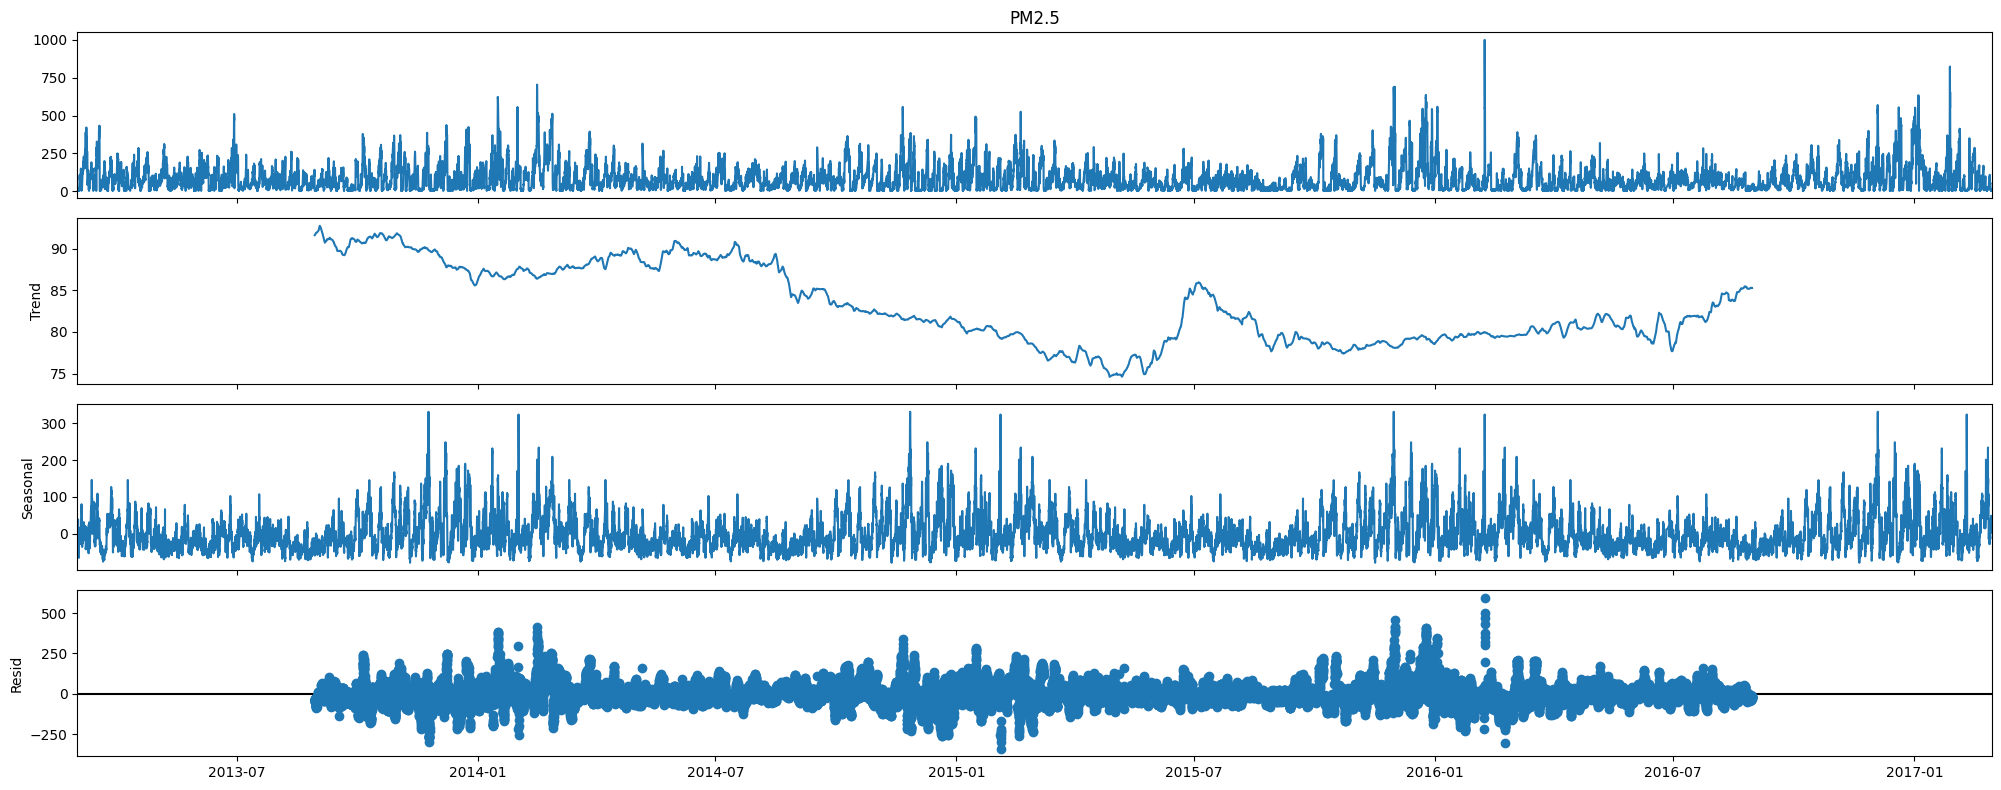

In [5]:
# initial analysis of data

print(df.info())
print(df.describe())

correlation_matrix = df.corr()
plt.rcParams['figure.figsize'] = (20, 8)
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation matrix')
plt.show()

# seasonal_decompose can't handle missing values
print(df.isna().sum())
df = df[df['PM2.5'].notnull()]
df = df.ffill()

df.plot()
results = seasonal_decompose(df['PM2.5'], period=8640)
fig = results.plot()

In [6]:
# data processing

X = df.drop(columns=['PM2.5'], axis=1)
y = df[['PM2.5']]

sscX = StandardScaler()
for name, values in X.items():
    X[name] = sscX.fit_transform(pd.DataFrame(X.loc[:,name]))

sscY = StandardScaler()
y = pd.DataFrame(sscY.fit_transform(y))

In [7]:
# preparing time series

X_train = X.iloc[:-round(0.1*(len(df)))]
y_train = y.iloc[:-round(0.1*(len(df)))]
X_test = X.iloc[-round(0.1*(len(df))):]
y_test = y.iloc[-round(0.1*(len(df))):]

n_window = 24
n_features = X.shape[1]
n_batch = 256
timeseries_train = timeseries_dataset_from_array(X_train,
                                                 y_train,
                                                 sequence_length=n_window,
                                                 batch_size=n_batch)
timeseries_test = timeseries_dataset_from_array(X_test,
                                                y_test,
                                                sequence_length=n_window,
                                                batch_size=n_batch)

In [8]:
# preparing neural network

model = Sequential()
model.add(Input((n_window, n_features)))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(8))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['r2_score'])
model.summary()

history = model.fit(timeseries_train,
                    validation_data=timeseries_test,
                    epochs=150,
                    callbacks=[EarlyStopping(monitor='val_loss',
                                             patience=30,
                                             restore_best_weights=True)])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │        71,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 32)         │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 8)              │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,097 (363.66 KB)

 Trainable params: 93,097 (363.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.6127 - r2_score: 0.2820 - val_loss: 1.2416 - val_r2_score: 0.3412
Epoch 2/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.4962 - r2_score: 0.4178 - val_loss: 0.9960 - val_r2_score: 0.4715
Epoch 3/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.3887 - r2_score: 0.5412 - val_loss: 0.6282 - val_r2_score: 0.6666
Epoch 4/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.3354 - r2_score: 0.6044 - val_loss: 0.5241 - val_r2_score: 0.7219
Epoch 5/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.2817 - r2_score: 0.6672 - val_loss: 0.4680 - val_r2_score: 0.7517
Epoch 6/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.2415 - r2_score: 0.7132 - val_loss: 0.3989 - val_r2_score: 0.7884
Epoch 7/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.2156 - r2_score: 0.7453 - val_loss: 0.4260 - val_r2_score: 0.7740
Epoch 8/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.2208 - r2_score: 0.7397 -

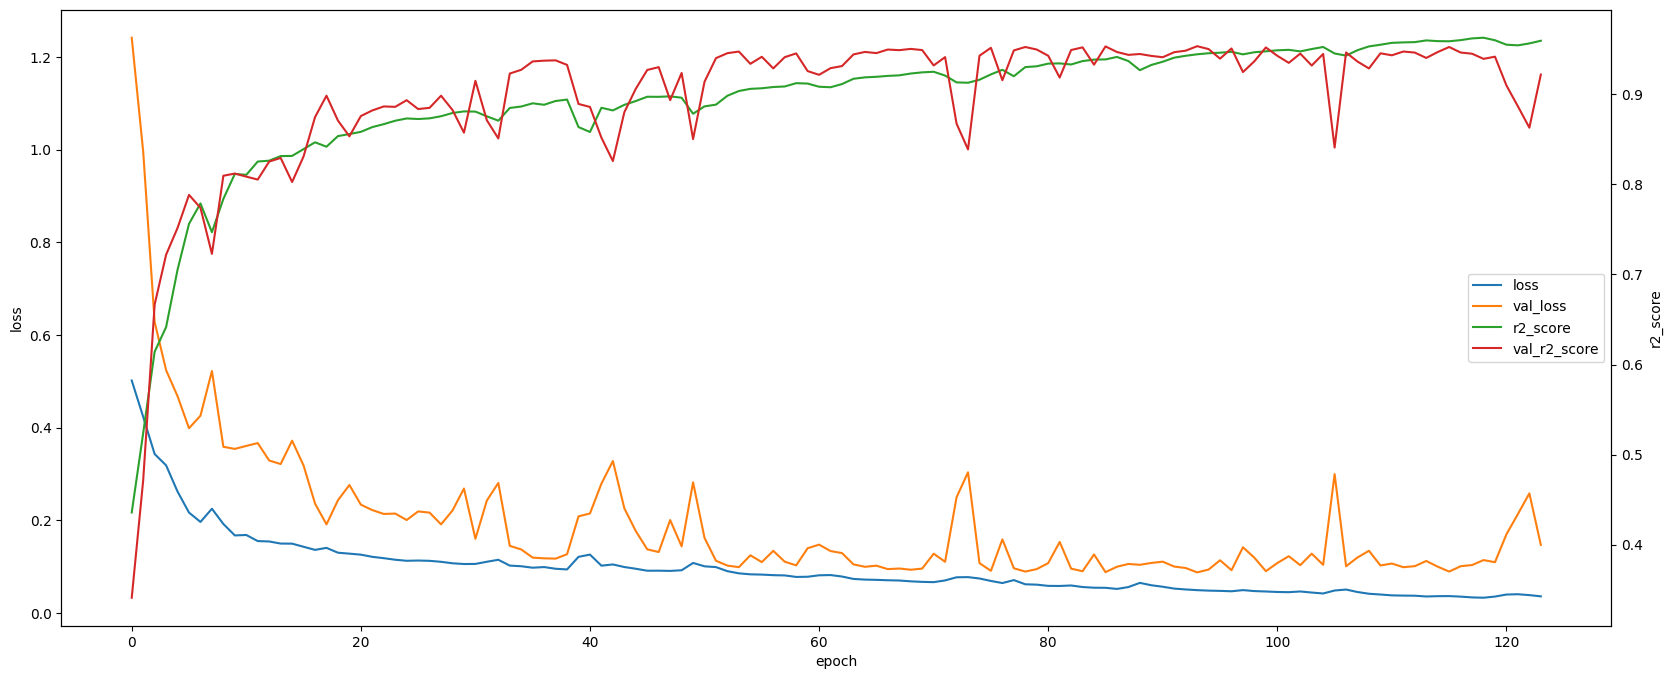

In [9]:
# neural network learning process parameters

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
l1, = ax1.plot(history.history['loss'], '-', color='C0', label='loss')
l2, = ax1.plot(history.history['val_loss'], '-', color='C1', label='val_loss')
l3, = ax2.plot(history.history['r2_score'], '-', color='C2', label='r2_score')
l4, = ax2.plot(history.history['val_r2_score'], '-', color='C3', label='val_r2_score')
ax1.set_xlabel("epoch")
ax1.set_ylabel('loss')
ax2.set_ylabel('r2_score')
plt.legend(handles=[l1, l2, l3, l4], loc='center right');

In [10]:
# predicting values of PM2.5

y_train = sscY.inverse_transform(y_train[:-23])
y_train_pred = sscY.inverse_transform(model.predict(timeseries_train))
y_test = sscY.inverse_transform(y_test[:-23])
y_test_pred = sscY.inverse_transform(model.predict(timeseries_test))

df_train_pred = pd.DataFrame(y_train_pred,
                             index=X_train.index[:-23],
                             columns=['Prediction'])
df_test_pred = pd.DataFrame(y_test_pred,
                            index=X_test.index[:-23],
                            columns=['Prediction'])

121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [11]:
# calculating R2 parameter to check quality of prediction

r2_train = r2_score(y_train_pred, y_train)
r2_test = r2_score(y_test_pred, y_test)
print(f'r2_train: {r2_train:.4f}')
print(f'r2_test: {r2_test:.4f}')
print(f'mse_train: {mean_squared_error(y_train_pred, y_train):.4f}')
print(f'mse_test: {mean_squared_error(y_test_pred, y_test):.4f}')

r2_train: 0.9261
r2_test: 0.9476
mse_train: 479.7319
mse_test: 649.0521


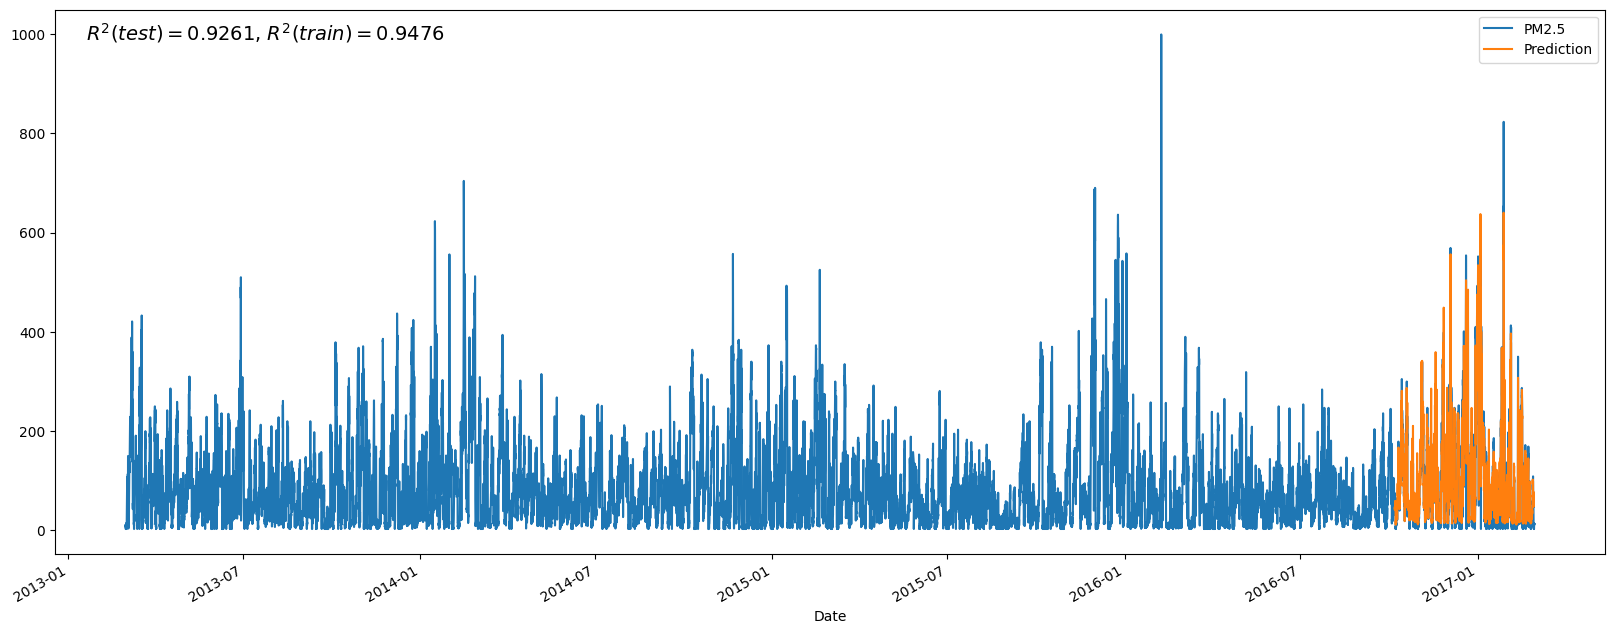

In [12]:
# visualising prediction of PM2.5

ax = df[['PM2.5']].plot()
df_test_pred.plot(ax = ax)
ax.text(0.02, 0.98,
        f"$R^2(test) = ${r2_train:.4f}, $R^2(train) = ${r2_test:.4f}",
        transform=ax.transAxes,
        fontsize=14,
        verticalalignment='top');